# The Orbital Surface Density Distribution and Multiplicity of M-Dwarfs

For this work, I redo my research project using an MCMC routine instead of the manual method I was using before. I use the same data, which was processed in a separate Jupyter Notebook. The results of this are saved in derived_data.py, which is imported towards the beginning of the code.  

## Introduction

M-Dwarfs are among the most numerous stars in the universe,
and many exist alongside at least one companion. Knowing the fraction of M-Dwarfs which have a stellar companion
will have important implications for star formation theories, inform
us about the emergence of planetary systems around low
mass stars, and allow for the modeling of both galactic and extragalactic
stellar populations. Fundamentally, the multiplicity fraction of a population of stars depends on the companion mass ratio distribution ($\psi$) and the orbital surface density distribution ($\phi$). The mass ratio, $q$, is defined as: $\frac{M_{secondary}}{M_{primary}}$ where, by definition, $M_{primary} \geq M_{secondary}$ so that $q \leq 1$. Furthermore, the semi-major axis, $a$, of a system serves as a measure of the separation between the primary and secondary stars. Using these two components, we calculate the multiplicity fraction as: \begin{equation}
    f = \int_{q_{min}}^{q_{max}}\psi dq * \int_{log_{10}a_{min}}^{log_{10}a_{max}}\phi dlog_{10}(a)\label {eq:1}
\end{equation} where $q_{min}, q_{max}, a_{min},$ and $a_{max}$ represent the lower and upper bounds for the regions of mass ratio and semi-major axis of interest. The first integral, the companion mass ratio distribution, is discussed in Reggiani \& Meyer (2013). The authors of this paper find that the formula: \begin{equation}
    \psi = q^{.25 \pm 0.29} \label{eq:2} 
\end{equation}describes this distribution for M-Dwarfs and other types of stars. This work is focused on finding the functional form for $\phi$ in the first equation, the orbital surface density distribution. This is assumed to be a log-normal probability density function of the form: \begin{equation}
   \phi = A * \frac{e^{-(log_{10}(a) - log_{10}(\mu))^{2} / (2log_{10}(\sigma)^{2} )}}{log_{10}(\sigma)*\sqrt{2\pi}} \label{eq:3} \end{equation}
   with three parameters: amplitude ($A$), base-10 log of mean ($log_{10}\mu$), and base-10 log of standard deviation ($log_{10}\sigma$). Once these parameters are determined, the first equation can be used to calculate the multiplicity of M-Dwarfs by integrating over specific ranges of mass ratio and semi-major axis. 
   
To this end, point estimates of the multiplicity fraction were compiled from five literature sources (one data set was split in to two, leading to six total estimates) which are at least 90% complete over specifics ranges of semi-major axis and are collectively at least 90% complete over the mass ratio range of 0.60 - 1.00. These multiplicity estimates would serve as the data in the model-fitting process below. The crux of this work is the MCMC routine which is used to fit the log-normal model to this data.

## Initializations

Importing packages and libraries. 

Note: I made derived_data so that file must be downloaded alongside this notebook. 

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
rcParams['legend.frameon'] = False
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import derived_data as d # file with data derived during my data analyis process
import emcee
import corner
from scipy.stats import chi2
from astroML.plotting import scatter_contour
from scipy.optimize import curve_fit
from scipy import optimize, stats

First, I define the equations above as functions. I also specify the bounds of integration for the regions of q and a, which will be used throughout the following work. These specific bounds come from that data I used. Each data set is representative over a specific range of semi-major axis; the smallest of these being 1e-10 AU and the largest being 10,000 AU. Every data set is representative over the range of mass ratio 0.60 - 1.00. 

Nu, the degrees of freedom, is the number of data sets (6) minus the number of fitted parameters (3) and is used the reduced chi-squared test.

In [2]:
def log_normal_pdf(x, mu, sigma):
    return (np.exp(-((x - mu)**2 / (2 * sigma**2)))) / (sigma * np.sqrt(2 * np.pi))

def phi(mu, sigma, a_min, a_max):
    return integrate.quad(lambda a: log_normal_pdf(a, mu, sigma), a_min, a_max)[0]

def psi(q_min, q_max):
    return integrate.quad(lambda q: q**.25 , q_min, q_max)[0]

def frequency(amp, q_min, q_max, mu, sigma, a_min, a_max):
    return amp * psi(q_min, q_max) * phi(mu, sigma, a_min, a_max)

nu = 3
def red_chi_sq(nu, model, data, error):
    return sum((1/nu) * np.power(np.subtract(data, model), 2) / np.power(error, 2))

q_min = 0.6
q_max = 1.0
a_min = 1e-10
a_max = 10000

Next, I initialize the Bayesian formulas that are used in my MCMC routine. The model values are integrated over the ranges of semi-major axis which each data set (denoted by CC, Del, Jan, FM, WD_A, WD_B) is representative over. The data and error values come from the data analysis work I did some time ago. The likelihood is defined in terms of a chi-squared test. I use uniform priors with bounds informed by my previous work. 

In [3]:
def lnLikelihood(p): # p[] = A, mu, sigma
    f_CC = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
    f_Del = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
    f_Jan = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
    f_FM = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
    f_WD_A = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))
    f_WD_B = frequency(p[0], q_min, q_max, p[1], p[2], np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))
    
    models = [f_CC, f_Del, f_Jan, f_FM, f_WD_A, f_WD_B]
    data = [d.f_CC, d.f_Del, d.f_Jan, d.f_FM, d.f_WD_A, d.f_WD_B]
    errors = [d.e_CC, d.e_Del, d.e_Jan, d.e_FM, d.e_WD_A, d.e_WD_B]
    
    ll = np.nan_to_num(-0.5 * sum(np.power(np.subtract(data, models), 2) / np.power(errors, 2)))

    return ll

def lnPrior(p):
    if not (0 < p[0] < 2): # wide: 0 - 2
        return -np.inf
    if not (-1 < p[1] < 2): # wide: -2 - 5, narrow: -1 - 2
        return -np.inf
    if not (-1 < p[2] < 2): # wide: -2 - 4, narrow: -1 - 2
        return -np.inf        
    return 0.0

def lnPosterior(p):
    return lnPrior(p) + lnLikelihood(p)

## MCMC

Here I define and run the MCMC routine with 3 dimensions, 100 walkers, 5000 steps, and random (within the bounds of the prior) initial walker positions. I save the autocorrelation times, which will help in the analysis

In [4]:
ndim = 3
nwalkers = 100
nsteps = 5000
np.random.seed(0)

p0 = np.reshape([[np.random.uniform(0, 2, 1), np.random.uniform(-1, 2, 1), np.random.uniform(-1, 2, 1)] for i in range(nwalkers)], (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)
sampler.run_mcmc(p0, nsteps)

times = sampler.get_autocorr_time()


Next, I plot the entire flattened chains for each of the three parameters. These plots allow me to visually estimate what the burn-in values should be. I decide that a burn-in of 200 sufficiently gets rid of the wide variance in each of the flat chains. 

[36.62081352 39.21001242 37.18922005]
753.4669732129056


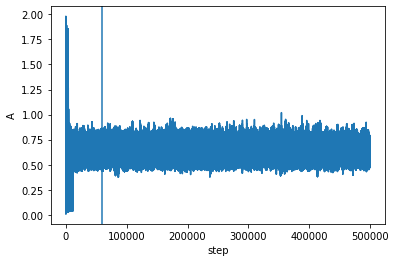

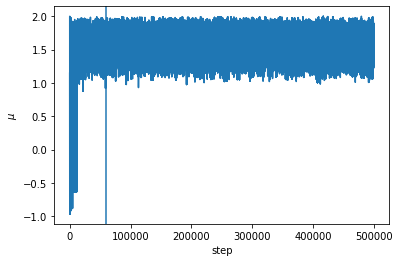

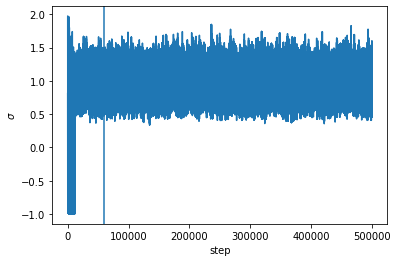

In [5]:
print(times)
print(20 * np.mean(times))
burns = 600

plt.plot(sampler.flatchain[:,0])
plt.axvline(100 * burns)
plt.xlabel("step")
plt.ylabel("A")
plt.show()
plt.plot(sampler.flatchain[:,1])
plt.axvline(100 * burns)
plt.xlabel("step")
plt.ylabel("$\mu$")
plt.show()
plt.plot(sampler.flatchain[:,2])
plt.axvline(100 * burns)
plt.xlabel("step")
plt.ylabel("$\sigma$")
plt.show()

Next, I cut out the burn in values for each of the parameters. 

In [6]:
samples = sampler.chain[:, burns:, :].reshape((-1, 3))
A_vals = samples[:,0]
mu_vals = samples[:,1]
sigma_vals = samples[:,2]

I plot the corner plots from the MCMC process to depict the distributions of each parameter. 

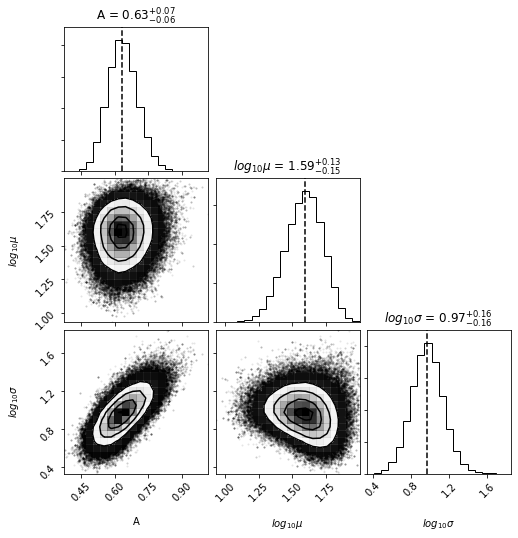

In [7]:
corner.corner(samples, labels=['A', '$log_{10}\mu$', '$log_{10}\sigma$'], quantiles=[0.5], show_titles=True)
plt.savefig("corner.jpeg", format = "jpeg", quality = 95)
plt.show()


I find it interesting that the mutual distribution of $\sigma$ and A seems to be correlated. I fit a line to this distribution and run Pearson's correlation test. I find that the line $\sigma = 1.75 * A - 0.15$ describes this, and a correlation coefficient of 0.70 suggests a strong linear correlation between the two parameters. 

best fit slope, intercept =  1.7482343607697721 -0.14250290482270195
correlation coefficient, p =  (0.6986140995033037, 0.0)


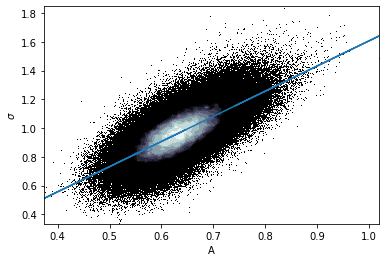

In [8]:
def lin_chi2(p):
    return np.sum((sigma_vals-p[1]-p[0]*A_vals)**2/(np.std(A_vals)**2 + np.std(sigma_vals)**2))

o = optimize.minimize(lin_chi2, [1, 0])
print("best fit slope, intercept = ", o.x[0], o.x[1])

print("correlation coefficient, p = ", stats.pearsonr(A_vals, sigma_vals))

scatter_contour(A_vals, sigma_vals, threshold=400, log_counts=True, histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='black'), contour_args=dict(cmap=plt.cm.bone))
# plt.plot(A_vals, popt[0] * A_vals + popt[1])
plt.plot(A_vals, o.x[0] * A_vals + o.x[1])
plt.xlabel("A")
plt.ylabel("$\sigma$")
plt.show()

I print out the best fit parameter values, the associated reduced chi-squared parameter value, and the probability of achieving a chi-squared value at least as extreme as this. At the 0.05 significance level, I fail to reject the null hypothesis that the data comes from this model. Therefore, the model descibes the data.

In [9]:
best_A = np.mean(sampler.flatchain[:,0])
best_mu = np.mean(sampler.flatchain[:,1])
best_sigma = np.mean(sampler.flatchain[:,2])
print(best_A, best_mu, best_sigma)

f_CC = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC))
f_Del = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del))
f_Jan = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan))
f_FM = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM))
f_WD_A = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A))
f_WD_B = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B))

models = [f_CC, f_Del, f_Jan, f_FM, f_WD_A, f_WD_B]
data = [d.f_CC, d.f_Del, d.f_Jan, d.f_FM, d.f_WD_A, d.f_WD_B]
errors = [d.e_CC, d.e_Del, d.e_Jan, d.e_FM, d.e_WD_A, d.e_WD_B]

p = integrate.quad(lambda x: chi2.pdf(x, nu) , nu * red_chi_sq(nu, models, data, errors), np.inf)[0]
print(red_chi_sq(nu, models, data, errors), p)

0.636918590120549 1.5768435192694514 0.9678538009187231
2.1436543483754895 0.09242527589929078


## Analysis of Results

I use the best-fit parameter values to calculate a frequency. I find that the multiplicity fraction of M-Dwarfs is about 24%. 

In [10]:
best_f = frequency(best_A, q_min, q_max, best_mu, best_sigma, np.log10(a_min), np.log10(a_max))
print(best_f)


0.23898835260068235


The next step is to compute the error of the frequency. To do this, I first create a histogram of 1,000 randomly sampled frequency values. I use a top-hat kernal density estimation to find a continuous distribution which can describe this histogram. 

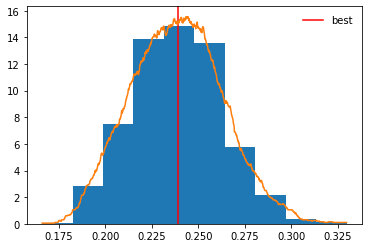

In [11]:
# for i in np.sort(A_vals[:10]):
#     for j in np.sort(mu_vals[:10]):
#         for k in np.sort(sigma_vals[:10]):
#             print(i, j, k)

N = 1000

stacked = np.stack((A_vals, mu_vals, sigma_vals)) 
A_sample = np.random.choice(stacked[0], N)
mu_sample = np.random.choice(stacked[1], N)
sigma_sample = np.random.choice(stacked[0], N)

freq_sample = []
for i, j, k in zip(A_sample, mu_sample, sigma_sample):
    freq_sample.append(frequency(i, q_min, q_max, j, k, np.log10(a_min), np.log10(a_max)))
    
plt.hist(freq_sample, density = True)  
plt.axvline(best_f, color = "red", label = "best")

def kde_th(x, data, h):
    f = []
    n = len(data)
    a = b = 0
    u = [(x - i)/h for i in data]
    k = np.zeros(np.shape(u))
    for i in np.abs(u):
        for j in i:
            if j <= 1:
                k[a][b] = 0.5
            elif j > 1:
                k[a][b] = 0
            b += 1
        a += 1
        b = 0
    f = 1/(n * h) * sum(k)
    return(f)

x = np.linspace(min(freq_sample), max(freq_sample), N)
kde = kde_th(x, freq_sample, .01)

plt.plot(x, kde)
plt.legend()
plt.show()

I calculate the cumulative distribution function of the frequency values using a cumulatie integral, and the find the 68.3% and 90% confidence levels of the frequency distribution. In the end, I report the error on the frequency as the 90% confidence level. 

### This leads to a multiplicity fraction of M-Dwarfs of 0.239 +/- 0.04 
(over these specifics ranges of q and a).

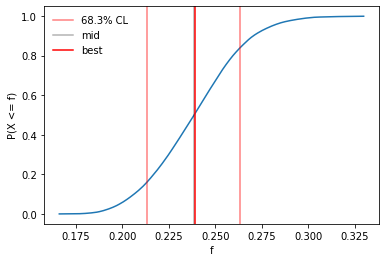

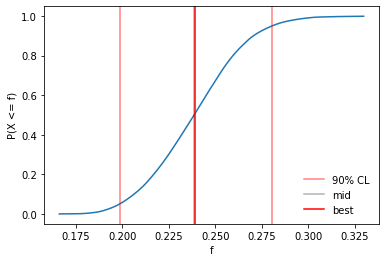

0.00036080099252802644
ANSWER: f = 0.23898835260068235 +/- 0.041455113894284024 0.04053687607985726


In [12]:
cdf = integrate.cumtrapz(kde, x, initial=0)

level = [.683, .9]
labs = ["68.3% CL", "90% CL"]
lower_bound = []
upper_bound = []
for i, l in zip(level, labs):

    lower = []
    upper = []
    mid = []
    upper_limit = .5 + i / 2
    lower_limit = .5 - i / 2
    for i in range(len(cdf)):
        lower.append(np.abs(cdf[i] - lower_limit))
        upper.append(np.abs(cdf[i] - upper_limit))
        mid.append(np.abs(cdf[i] - .50)) 

    lower_bound.append(x[np.where(lower == min(lower))[0][0]])
    upper_bound.append(x[np.where(upper == min(upper))[0][0]])
    mid = x[np.where(mid == min(mid))[0][0]]

    plt.plot(x, cdf)
    plt.xlabel("f")
    plt.ylabel("P(X <= f)")
    plt.axvline(lower_bound[-1], alpha = .5, color = "red", label = l)
    plt.axvline(mid, alpha = .3, color = "black", label = "mid")
    plt.axvline(upper_bound[-1], alpha = .5, color = "red")
    plt.axvline(best_f, color = "red", label = "best")
    plt.legend()
    plt.show()
    
print(abs(mid - best_f))
# print(best_f - lower_bound[0], best_f, best_f + upper_bound[0])
# print(best_f - lower_bound[1], best_f, best_f + upper_bound[1])
print("ANSWER: f =", best_f, "+/-", upper_bound[1] - best_f, best_f - lower_bound[1])

Next, I plot the orbital surface density distribution, which is a log-normal probability distribution function with the parameters that I found above.

C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


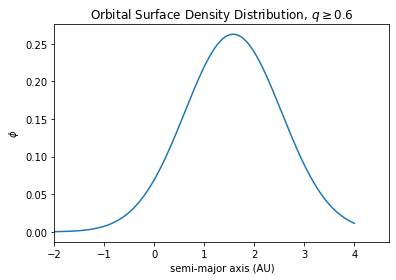

In [13]:
a = np.linspace(a_min, a_max, 1e6)
x = np.log10(a)
pdf = best_A * log_normal_pdf(x, best_mu, best_sigma)

plt.plot(x, pdf)
plt.ylabel('$\phi$')
plt.xlabel("semi-major axis (AU)")
plt.xlim(-2)
plt.title("Orbital Surface Density Distribution, $q \geq 0.6$")
plt.show()

# fig, ax1 = plt.subplots()
# ax1.plot(x, pdf, 'b-')
# ax1.set_xlabel('semi-major axis (AU)')
# ax1.set_ylabel('$\phi$', color='b')
# ax1.set_xlim(-2)
# ax1.tick_params(axis='y', which='both', left=False, labelleft=False)
# ax1.tick_params('y', colors='b')

# dq = phi(q_min, q_max)

# ax2 = ax1.twinx()
# ax2.set_xlim(np.log10(a_min), np.log10(a_max))
# ax2.set_ylabel('f / $\int\psi dq = \int\phi dlog_{10}(a)$', color='r')
# ax2.hlines(d.f_CC / dq, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC), color = "red")
# ax2.hlines(d.f_Del / dq, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del), color = "red")
# ax2.hlines(d.f_Jan / dq, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan), color = "red")
# ax2.hlines(d.f_FM / dq, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM), color = "red")
# ax2.hlines(d.f_WD_A / dq, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A), color = "red")
# ax2.hlines(d.f_WD_B / dq, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B), color = "red")

# ax2.scatter(np.median([np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC)]), d.f_CC - )
# ax2.scatter(np.median([np.log10(1e-2), np.log10(d.max_sep_limit_Del)]), d.f_Del)
# ax2.scatter(np.median([np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan)]), d.f_Jan)
# ax2.scatter(np.median([np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM)]), d.f_FM)
# ax2.scatter(np.median([np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A)]), d.f_WD_A)
# ax2.scatter(np.median([np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)]), d.f_WD_B)

# ax2.annotate('CC', xy=(np.median([np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC)]), d.f_CC))
# ax2.annotate('Del', xy=(np.median([np.log10(1e-2), np.log10(d.max_sep_limit_Del)]), d.f_Del))
# ax2.annotate('Jan', xy=(np.median([np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan)]), d.f_Jan))
# ax2.annotate('FM', xy=(np.median([np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM)]), d.f_FM))
# ax2.annotate('WD_A', xy=(np.median([np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A)]), d.f_WD_A))
# ax2.annotate('WD_B', xy=(np.median([np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)]), d.f_WD_B))

Finally, I summarize the frequency estimates compiled from the source data and those derived from my model. The red horizontal lines are the frequency estimates from the data, which are representative over range of semi-major axis covered by the widths of each line and have an errors denoted by the centered vertical lines. The blue horizontal lines are the frequency I calculate using my model of the same regions of semi-major axis. One can see that the blue lines do not always fall within error of the red lines, which indicates the middling accuracy of my model.

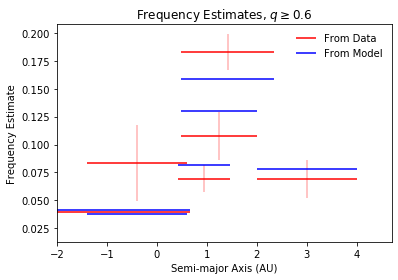

In [14]:
plt.hlines(d.f_CC, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC), color = "red", label = "From Data")
plt.hlines(d.f_Del, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del), color = "red")
plt.hlines(d.f_Jan, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan), color = "red")
plt.hlines(d.f_FM, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM), color = "red")
plt.hlines(d.f_WD_A, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A), color = "red")
plt.hlines(d.f_WD_B, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B), color = "red")

plt.vlines(np.median([np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC)]), d.f_CC - d.e_CC, d.f_CC + d.e_CC, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del)]), d.f_Del - d.e_Del, d.f_Del + d.e_Del, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan)]), d.f_Jan - d.e_Jan, d.f_Jan + d.e_Jan, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM)]), d.f_FM - d.e_FM, d.f_FM + d.e_FM, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A)]), d.f_WD_A - d.e_WD_A, d.f_WD_A + d.e_WD_A, color = "red", alpha = 0.3)
plt.vlines(np.median([np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B)]), d.f_WD_B - d.e_WD_B, d.f_WD_B + d.e_WD_B, color = "red", alpha = 0.3)

plt.hlines(f_CC, np.log10(d.min_sep_limit_CC), np.log10(d.max_sep_limit_CC), color = "blue", label = "From Model")
plt.hlines(f_Del, np.log10(d.min_sep_limit_Del), np.log10(d.max_sep_limit_Del), color = "blue")
plt.hlines(f_Jan, np.log10(d.min_sep_limit_Jan), np.log10(d.max_sep_limit_Jan), color = "blue")
plt.hlines(f_FM, np.log10(d.min_sep_limit_FM), np.log10(d.max_sep_limit_FM), color = "blue")
plt.hlines(f_WD_A, np.log10(d.min_sep_limit_WD_A), np.log10(d.max_sep_limit_WD_A), color = "blue")
plt.hlines(f_WD_B, np.log10(d.min_sep_limit_WD_B), np.log10(d.max_sep_limit_WD_B), color = "blue")

plt.xlabel("Semi-major Axis (AU)")
plt.ylabel("Frequency Estimate")
plt.title("Frequency Estimates, $q \geq 0.6$")
plt.legend()
plt.xlim(-2)
plt.savefig("freqs.jpeg", format = "jpeg", quality = 95)
plt.show()